In [1]:
import numpy as np
from matplotlib import pyplot as plt

from wpg.optical_elements import Drift
from wpg.wpg_uti_oe import propagation_parameters
from wpg.source import sase_pulse
from midsim.source import analytical_pulse_divergence, analytical_pulse_width

from wpg.beamline import Beamline

In [15]:
import numpy as np
from scipy.interpolate import griddata
from wpg.srwlib import SRWLOptT

def Mirror_plane_2d(orient, theta, length, range_xy, filename, nx=1500, ny=100, scale=1, x0=0., y0=0., xscale=1., yscale=1., bPlot=False):
    """
    Defining a plane mirror propagator with taking into account 2D surface height errors

    :param orient:  mirror orientation, 'x' (horizontal) or 'y' (vertical)
    :param theta:   incidence angle [rad]
    :param length:  mirror length, [m]
    :param range_xy: range in which the incident WF defined [m]
    :param filename: full file name with 2d mirror profile of three columns, x, y, and h(x, y) - height errors [m]
    :param scale: scale factor, optical path difference OPD = 2*h*scale*sin(theta)
    :param x0: shift of mirror longitudinal position [m]
    :param y0: shift of mirror transverse position [m]
    :param xscale: units of 1st column of filename,  x[m]=x[nits]*xscale  [m]
    :param yscale: units of 1st column of filename,  y[m]=y[nits]*yscale  [m]
    :return: opIPM  - imperfect plane mirror propagator
    """
    sinTheta = np.sin(theta)
    _height_prof_data = np.loadtxt(filename)
    
    # Assuming _height_prof_data has columns x, y, h
    x = _height_prof_data[:, 0] * xscale
    y = _height_prof_data[:, 1] * yscale
    h = _height_prof_data[:, 2]

    # Centering data around x0 and y0
    x = x - x0 - np.mean(x)
    y = y - y0 - np.mean(y)

    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    print('length: {:.1f} mm, width: {:.1f} mm'.format((xmax-xmin)*1e3, (ymax-ymin)*1e3))
    
    if (xmin <= -length/2.) and (xmax >= length/2):
        xmin = -length/2
        xmax = length/2
    else:
        raise ValueError(
            'specified length -{0:.0f}:{0:.0f} mm exceeds \'{1:s}\' mirror limits {2:.0f}:{3:.0f} mm'.format(
                length*1e3/2, os.path.basename(filename), xmin*1e3, xmax*1e3)
        )
    if (ymin <= -range_xy/2) and (ymax >= range_xy/2):
        ymin = -range_xy/2
        ymax = range_xy/2
    else:
        raise ValueError(
            'specified width -{0:.0f}:{0:.0f} mm exceeds \'{1:s}\' mirror limits {2:.0f}:{3:.0f} mm'.format(
                range_xy*1e3/2, os.path.basename(filename), ymin*1e3, ymax*1e3)
        )

    # Create the optical element
    if orient == 'y':
        opIPM = SRWLOptT(nx, ny, (ymax-ymin), (xmax-xmin)*sinTheta)
    elif orient == 'x':
        opIPM = SRWLOptT(nx, ny, (xmax-xmin)*sinTheta, (ymax-ymin))
    else:
        raise TypeError('orient should be "x" or "y"')

    # Create the mesh grid for x and y coordinates
    xnew, ynew = np.mgrid[xmin:xmax:nx*1j, ymin:ymax:ny*1j]

    # Perform 2D interpolation
    points = np.column_stack((x, y))
    h_new = griddata(points, h, (xnew, ynew), method='linear', fill_value=0)

    if bPlot:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.pcolor(xnew, ynew, h_new*scale*1e9)
        plt.axis([xnew.min(), xnew.max(), ynew.min(), ynew.max()])
        plt.colorbar(orientation='horizontal')
        plt.title('surface height errors map, nm')
        plt.show()

    auxMesh = opIPM.mesh
    from array import array
    foo = array('d', [1.]*nx*ny)
    opIPM.arTr[::2] = foo  # Amplitude Transmission

    # Vectorized calculation of Optical Path Difference
    opd = -2 * sinTheta * h_new.flatten() * scale
    opIPM.arTr[1::2] = array('d', opd)  # Optical Path Difference (to check sign!)

    return opIPM


In [16]:
# from wpg.optical_elements import Mirror_plane_2d
T = Mirror_plane_2d('x', theta = 1.2e-03, length = 848.7e-03,range_xy=19.2e-3,filename = '/Users/twguest/Downloads/JF061004_gi_2dmap.txt', nx = 1024)
T.name = 'T'

length: 848.7 mm, width: 19.2 mm


In [17]:
from matplotlib.colors import LogNorm, Normalize

def plot_wfr(wfr, logscale=False, title = None):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    intensity = wfr.get_intensity().sum(-1)
    
    if logscale:
        norm = LogNorm(vmin=intensity[intensity > 0].min(), vmax=intensity.max())
    else:
        norm = Normalize(vmin=intensity.min(), vmax=intensity.max())
    
    try:
        extent =  [a*1e3 for a in [wfr.xMin, wfr.xMax, wfr.yMin, wfr.yMax]]
        
    except(TypeError):
        extent =  [a*1e3 for a in [wfr.qxMin, wfr.qxMax, wfr.qyMin, wfr.qyMax]]

    im = ax.imshow(intensity,
                   extent=extent,
                   cmap='afmhot',
                   norm=norm)
    
    ax.set_xlabel('x (mm)')
    ax.set_xlabel('y (mm)')
    
    if title:
        ax.set_title(title)
    fig.colorbar(im, ax=ax, orientation='vertical')


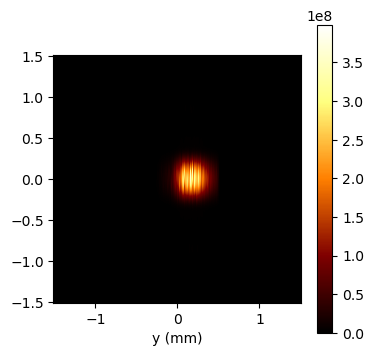

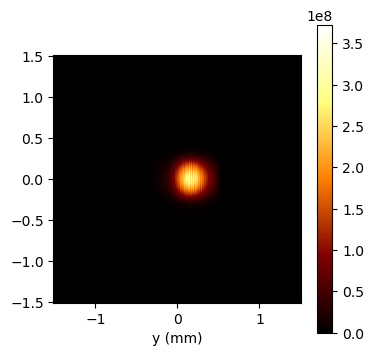

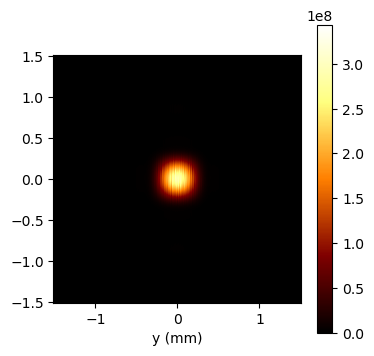

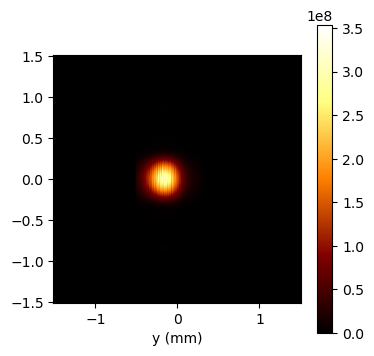

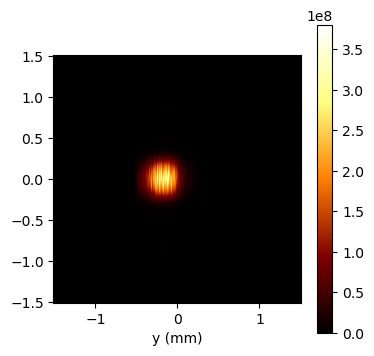

In [19]:
x = y = np.linspace(-500e-06, 500e-06, 512)
t = np.linspace(-50e-15, 50e-15, 2)

theta_y = 0
photon_energy = 10e3


theta_x = np.linspace(-2.5,2.5,5)*1e3
wavefronts = sase_pulse(x=x,
                        y=y,
                        t=t,
                        photon_energy=photon_energy,
                        pulse_energy=1e-03,
                        pulse_duration=15e-15,
                        bandwidth=1e-12,
                        sigma=analytical_pulse_width(photon_energy),
                        div=analytical_pulse_divergence(photon_energy),
                        x0=0.0,
                        y0=0.0,
                        t0=0.0,
                        theta_x=theta_x,
                        theta_y=0.0,
                        domain='freq',
                        polarization = 'horizontal')



for wfr in wavefronts:
    bl = Beamline()
    bl.append(Drift(290), propagation_parameters(3,1,3,1,mode = 'fresnel'))
    bl.append(T, propagation_parameters(1,1,1,1, mode = 'fresnel'))
    
    bl.append(Drift(1), propagation_parameters(1,1,1,1,mode = 'fresnel'))
    bl.propagate(wfr)

    plot_wfr(wfr)

In [78]:
T.mesh.a

AttributeError: 'SRWLRadMesh' object has no attribute 'a'